In [1]:
# Common imports
import numpy as np
from pprint import pprint

# to make this notebook's output stable across runs
np.random.seed(42)

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import log_loss
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV

# scipy
from scipy.stats import loguniform

# plotting imports
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# global settings
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

In [3]:
# Ignore all warnings (convergence..) by sklearn
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

In [ ]:
from sklearn.datasets import fetch_openml

X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

In [25]:
X = X_pd.to_numpy()
y = y_pd.to_numpy()

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [26]:
# initilize new variable names with all 0
y_train_0 = np.zeros((len(y_train)))
y_test_0 = np.zeros((len(y_test)))

# find indices with digit 0 image
indx_0 = np.where(y_train == '0')  # remeber original labels are of type str not int
# use those indices to modify y_train_0 and y_test_0
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

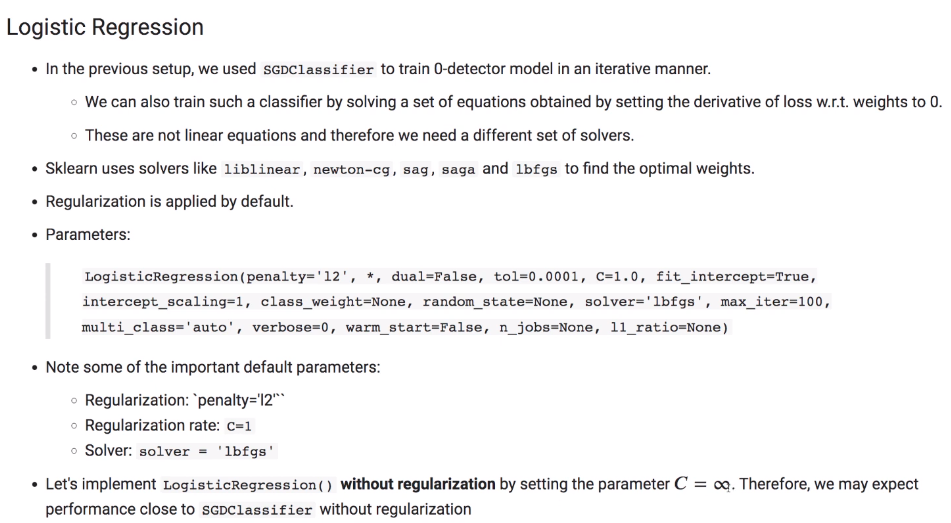  
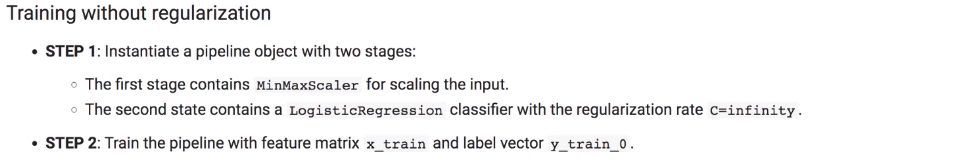

In [27]:
pipe_logit = make_pipeline(MinMaxScaler(),
                           LogisticRegression(random_state=1729,
                                              solver='lbfgs',
                                              C=np.infty))

pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])


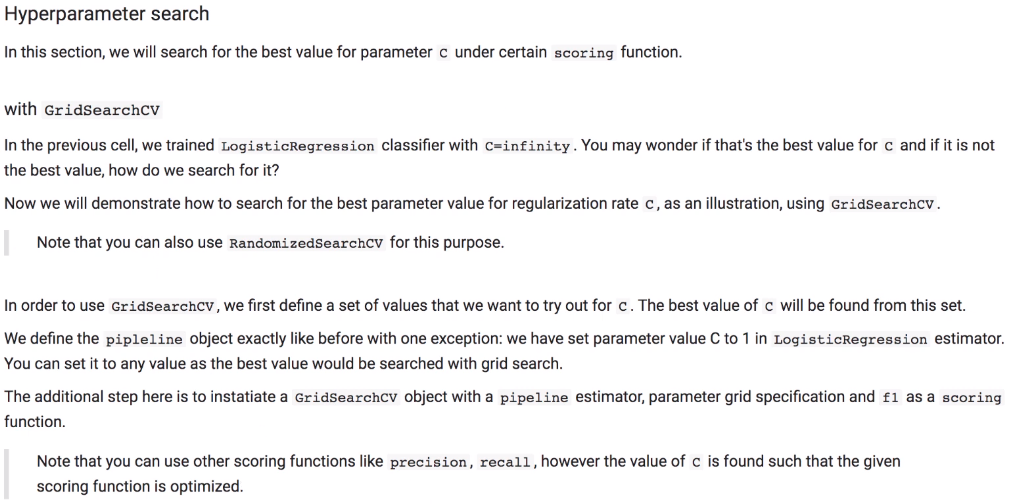

In [7]:
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()
logreg = LogisticRegression(C=1.0, random_state=1729)

pipe = Pipeline(steps=[('scaler', scaler),
                       ('logistic', logreg)])

pipe_logit_cv = GridSearchCV(
    pipe,
    param_grid = {'logistic__C': grid_Cs},
    scoring = 'f1')

pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

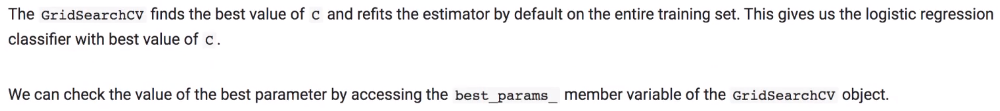

In [8]:
pipe_logit_cv.best_params_

{'logistic__C': 0.1}

In [9]:
pipe_logit_cv.best_score_

0.9579654953103655

In [10]:
pipe_logit_cv.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])

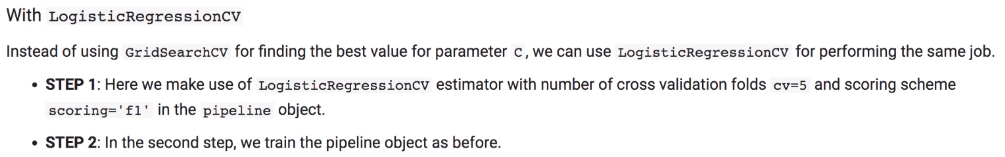

In [11]:
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(cv=5, random_state=1729, scoring='f1'))])

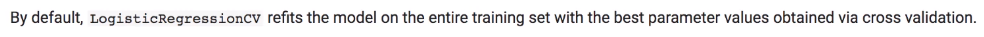
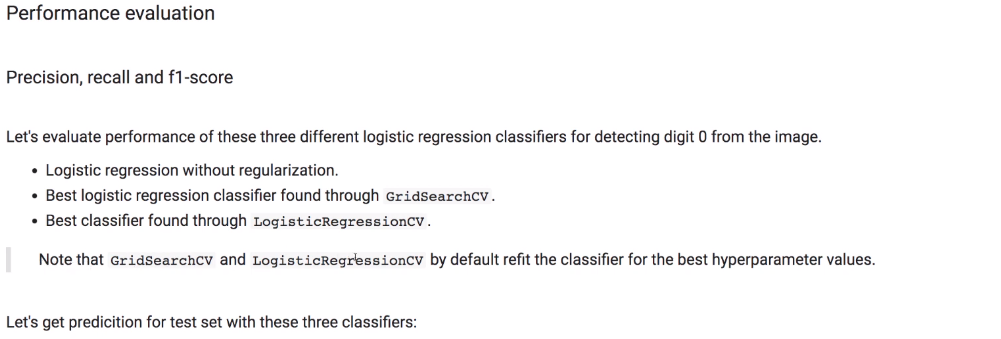

In [30]:
lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = logit_cv.predict(X_test)

In [31]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

In [34]:
print(f'LogReg: precision={precision_lr}, recall={recall_lr}')
print(f'GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}')
print(f'LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}')

LogReg: precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: precision=0.9564336372847011, recall=0.963265306122449
LogRegCV: precision=0.9546370967741935, recall=0.9663265306122449


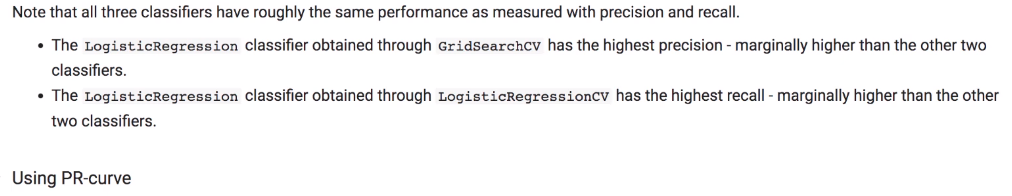

In [36]:
y_score_lr = pipe_logit.decision_function(X_test)
precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(y_test_0, y_score_lr)

y_score_lr_gs = pipe_logit_cv.decision_function(X_test)
precisions_lr_gs, recalls_lr_gs, thresholds_lr_gs = precision_recall_curve(y_test_0, y_score_lr_gs)

y_score_lr_cv = logit_cv.decision_function(X_test)
precisions_lr_cv, recalls_lr_cv, thresholds_lr_cv = precision_recall_curve(y_test_0, y_score_lr_cv)

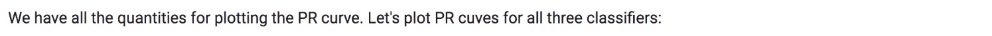

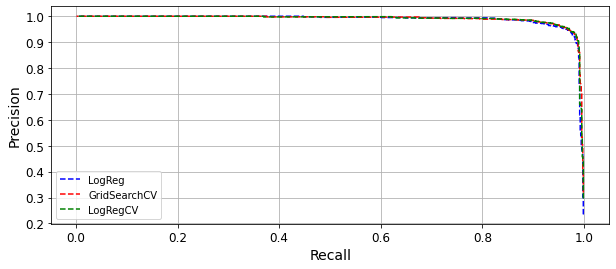

In [38]:
plt.figure(figsize=(10,4))
plt.plot(recalls_lr[:-1], precisions_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precisions_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precisions_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend()
plt.show()

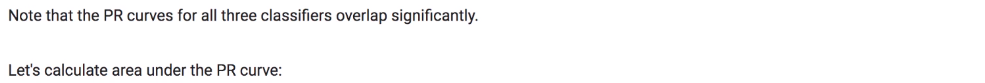

In [39]:
from sklearn.metrics import auc

auc_lr = auc(recalls_lr[:-1], precisions_lr[:-1])
auc_lr_gs = auc(recalls_lr_gs[:-1], precisions_lr_gs[:-1])
auc_lr_cv = auc(recalls_lr_cv[:-1], precisions_lr_cv[:-1])

In [40]:
print('AUC-PR for logistic regression:', auc_lr)
print('AUC-PR for grid search:', auc_lr_gs)
print('AUC-PR for logistic regression CV:', auc_lr)

AUC-PR for logistic regression: 0.9871337497759658
AUC-PR for grid search: 0.9886520703587929
AUC-PR for logistic regression CV: 0.9871337497759658


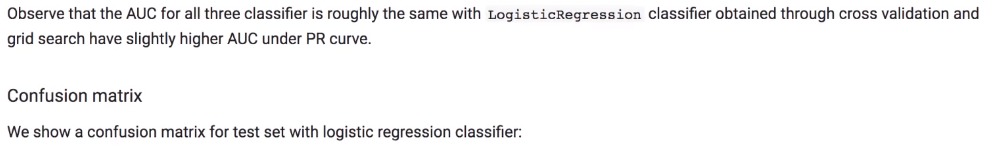

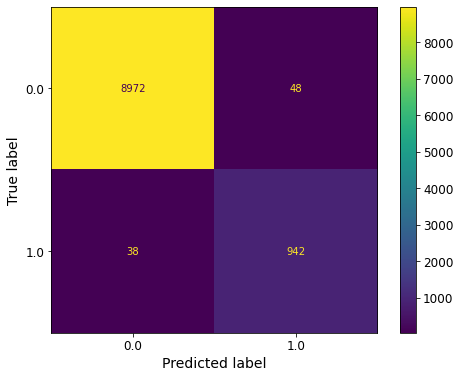

In [41]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='.5g')

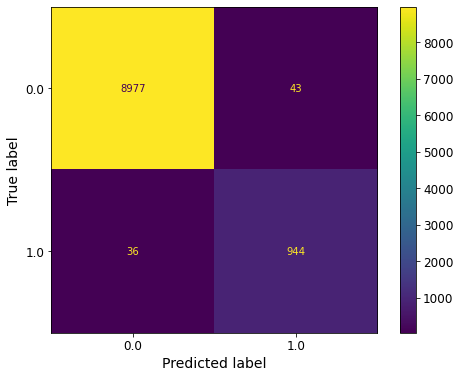

In [42]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='.5g')

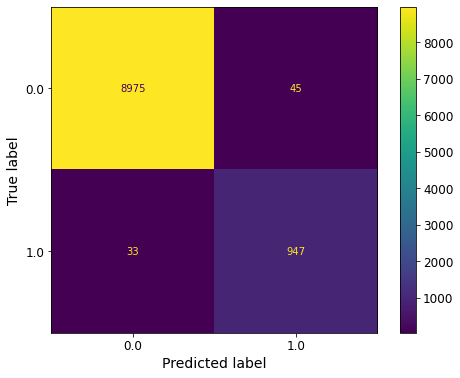

In [43]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='.5g')